# Installations

In [ ]:
# Installations

# install once necessary libraries

!pip install pandas
!pip install -U scikit-learn
!pip install pm4py
!pip install kneed
!pip install torch
!pip install Levenshtein

# Import Event Log

In [1]:
import pandas as pd
import numpy as np
import pm4py
from pm4py.objects.conversion.log import converter as log_converter


if __name__ == "__main__":
    # Read the CSV file
    dataframe = pd.read_csv('model_A.csv', sep=',')  

    # Drop the first column without knowing its name
    dataframe = dataframe.drop(dataframe.columns[0], axis=1)

    # Format the dataframe
    dataframe = pm4py.format_dataframe(
        dataframe, 
        case_id='case:concept:name', 
        activity_key='concept:name', 
        timestamp_key='time:timestamp'
    )

    # Convert the dataframe to event log
    log = log_converter.apply(dataframe)
    
dataframe

/Users/mert2/.conda/envs/thesis/lib/python3.11/site-packages/pm4py/objects/log/util/dataframe_utils.py:177: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)


,org:resource,lifecycle:transition,concept:name,time:timestamp,case:REG_DATE,case:concept:name,case:AMOUNT_REQ,@@index,@@case_index
0,112,COMPLETE,A_SUBMITTED,2011-10-01 00:38:44.546000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000,0,0
1,112,COMPLETE,A_PARTLYSUBMITTED,2011-10-01 00:38:44.880000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000,1,0
2,112,COMPLETE,A_PREACCEPTED,2011-10-01 00:39:37.906000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000,2,0
3,10862,COMPLETE,A_ACCEPTED,2011-10-01 11:42:43.308000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000,3,0
4,10862,COMPLETE,A_FINALIZED,2011-10-01 11:45:09.243000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000,4,0
...,...,...,...,...,...,...,...,...,...
60844,10933,COMPLETE,A_ACCEPTED,2012-03-01 20:17:22.457000+01:00,2012-02-29 23:43:09.766000+01:00,214373,8500,60844,13085
60845,10933,COMPLETE,A_FINALIZED,2012-03-01 20:22:38.593000+01:00,2012-02-29 23:43:09.766000+01:00,214373,8500,60845,13085
60846,112,COMPLETE,A_SUBMITTED,2012-02-29 23:51:16.799000+01:00,2012-02-29 23:51:16.799000+01:00,214376,15000,60846,13086
60847,112,COMPLETE,A_PARTLYSUBMITTED,2012-02-29 23:51:17.423000+01:00,2012-02-29 23:51:16.799000+01:00,214376,15000,60847,13086


# Data Preprocessing

In [2]:
# Group by '@@case_index' and join the 'concept:name' into a single string separated by a delimiter
grouped = dataframe.groupby('@@case_index')['concept:name'].apply(lambda x: ','.join(x)).reset_index()
grouped.columns = ['@@case_index', 'trace']

In [3]:
import Levenshtein

# First, find the unique traces and their indices
unique_traces = grouped['trace'].drop_duplicates()
num_unique_traces = len(unique_traces)

# Initialize a distance matrix for unique traces
unique_distance_matrix = np.zeros((num_unique_traces, num_unique_traces))

# Calculate Levenshtein distance for pairs of unique traces
for i in range(num_unique_traces):
    for j in range(i+1, num_unique_traces):
        distance = Levenshtein.distance(unique_traces.iloc[i], unique_traces.iloc[j])
        unique_distance_matrix[i, j] = distance
        unique_distance_matrix[j, i] = distance  # The distance is symmetric

In [4]:
# Let's assume you've extracted unique traces into a Series called `unique_traces`
unique_traces = grouped['trace'].drop_duplicates()

# Create a mapping from unique trace to an index
unique_trace_to_idx = {trace: idx for idx, trace in enumerate(unique_traces)}

# Add a 'unique_idx' column to `grouped` DataFrame
grouped['unique_idx'] = grouped['trace'].map(unique_trace_to_idx)

In [5]:
# Create a NumPy array from the 'unique_idx' Pandas Series for fast indexing
unique_idx_array = grouped['unique_idx'].to_numpy()

# Initialize a distance matrix for all traces
distance_matrix = np.zeros((len(grouped), len(grouped)))

# Populate the all_distance_matrix based on unique_distance_matrix
for i in range(len(grouped)):
    distance_matrix[i, :] = unique_distance_matrix[unique_idx_array[i], unique_idx_array]
    distance_matrix[:, i] = unique_distance_matrix[unique_idx_array, unique_idx_array[i]]

# Since distance is symmetric, and diagonal should be zeros
np.fill_diagonal(distance_matrix, 0)

In [6]:
# Find the maximum distance in the matrix
max_distance = np.max(distance_matrix)

# Avoid division by zero in case all distances are zero
if max_distance != 0:
    # Normalize the distance matrix
    normalized_distance_matrix = distance_matrix / max_distance
else:
    # If max_distance is 0, it means all distances are zero
    normalized_distance_matrix = distance_matrix

# Clustering

/Users/mert2/.conda/envs/thesis/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/mert2/.conda/envs/thesis/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/mert2/.conda/envs/thesis/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/mert2/.conda/envs/thesis/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default 

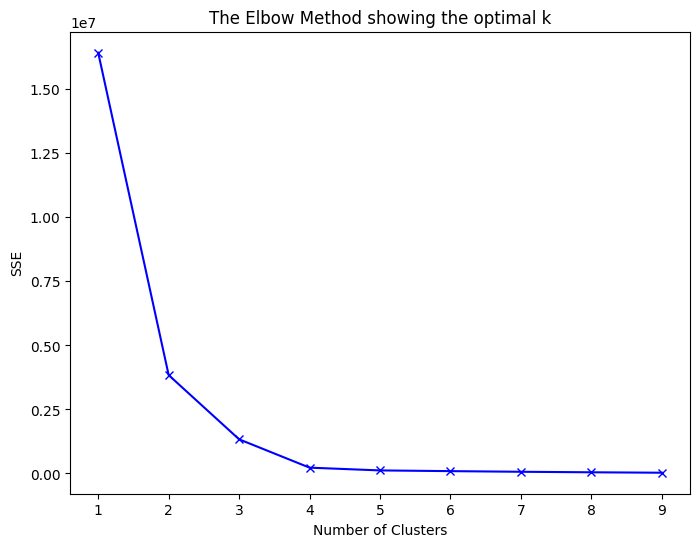

Optimal number of clusters: 3


In [7]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from kneed import KneeLocator

# Elbow method to determine the optimal number of clusters
distortions = []
K = range(1, 10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(normalized_distance_matrix)
    distortions.append(kmeanModel.inertia_)

# Plot the elbow graph
plt.figure(figsize=(8,6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('The Elbow Method showing the optimal k')
plt.show()

# Find the elbow point
kl = KneeLocator(range(1, 10), distortions, curve="convex", direction="decreasing")
print("Optimal number of clusters:", kl.elbow)

In [8]:
from sklearn.cluster import KMeans

# Number of clusters
k = kl.elbow

# Create a KMeans instance with k clusters
kmeans = KMeans(n_clusters=k, random_state=42)

# Fit the model to the data
kmeans.fit(normalized_distance_matrix)

# Predict the clusters for each trace
clusters = kmeans.predict(normalized_distance_matrix)

/Users/mert2/.conda/envs/thesis/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


# Cluster Evaluation

In [9]:
# the value of the silhouette coefficient ranges between -1 and 1
# value close to 1 is considered as good

from sklearn.metrics import silhouette_score

# Calculate silhouette score
silhouette_avg = silhouette_score(normalized_distance_matrix, clusters)

print(f"Silhouette Coefficient: {silhouette_avg:.2f}")

Silhouette Coefficient: 0.79


# Token-Based Replay for Conformance Checking

In [10]:
import pm4py
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.bpmn.importer import importer as bpmn_importer
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments_petri

# 2. Import the given BPMN model
bpmn_graph = bpmn_importer.apply("Model_A_corrected.bpmn")

# 3. Convert the BPMN to a Petri net
net, im, fm = pm4py.convert_to_petri_net(bpmn_graph)

# 4. Perform alignment-based conformance checking
alignments = alignments_petri.apply(log, net, im, fm)

# Calculate and print diagnostics
fit_traces = sum(1 for trace in alignments if trace['fitness'] == 1.0)

print(f"Total traces: {len(log)}")
print(f"Conform traces: {fit_traces}")
print(f"Non-Conform traces: {len(log) - fit_traces}")

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

Total traces: 13087
Conform traces: 11497
Non-Conform traces: 1590


# Happy Cluster

In [11]:
labels = kmeans.labels_

# Identify the dominant cluster
from collections import Counter
counter = Counter(labels)
happy_cluster = counter.most_common(1)[0][0]
print(f"Happy Cluster: {happy_cluster}")

Happy Cluster: 0


In [12]:
# Get the indices of the data points belonging to the happy cluster
happy_cluster_indices = np.where(clusters == happy_cluster)[0]

# Use these indices to fetch the corresponding data points from the original data X
happy_cluster_data_points = normalized_distance_matrix[happy_cluster_indices, :]

# Calculate the centroid as the mean of these data points
happy_cluster_centroid = np.mean(happy_cluster_data_points, axis=0)

print("Centroid of happy cluster:", happy_cluster_centroid)

Centroid of happy cluster: [0.93930989 0.93930989 0.93930989 ... 0.06960049 0.38108977 0.06960049]


# Distance Measurement

In [13]:
from scipy.spatial.distance import euclidean

# Calculate the Euclidean distance from each data point in X to the happy_cluster_centroid
distances_to_centroid = [euclidean(normalized_distance_matrix[i], happy_cluster_centroid) for i in range(len(normalized_distance_matrix))]

# Results overview

In [14]:
# create dataframe with necessary information for distance measurement

grouped = dataframe.groupby('@@case_index')['concept:name'].apply(list).reset_index(name='trace')

results = pd.DataFrame(grouped['trace'])

results['cluster'] = clusters

conformity_array = [int(trace['fitness']) for trace in alignments]
results['conform'] = conformity_array

results['distance'] = distances_to_centroid

,trace,cluster,conform,distance
0,"[A_SUBMITTED, A_PARTLYSUBMITTED, A_PREACCEPTED...",1,0,83.894932
1,"[A_SUBMITTED, A_PARTLYSUBMITTED, A_PREACCEPTED...",1,1,84.126070
2,"[A_SUBMITTED, A_PARTLYSUBMITTED, A_PREACCEPTED...",1,1,84.126070
3,"[A_SUBMITTED, A_PARTLYSUBMITTED, A_DECLINED]",0,1,7.350830
4,"[A_SUBMITTED, A_PARTLYSUBMITTED, A_DECLINED]",0,1,7.350830
...,...,...,...,...
13082,"[A_SUBMITTED, A_PARTLYSUBMITTED, A_PREACCEPTED...",2,0,38.253129
13083,"[A_SUBMITTED, A_PARTLYSUBMITTED, A_DECLINED]",0,1,7.350830
13084,"[A_SUBMITTED, A_PARTLYSUBMITTED, A_DECLINED]",0,1,7.350830
13085,"[A_SUBMITTED, A_PARTLYSUBMITTED, A_PREACCEPTED...",2,0,38.253129


In [15]:
summary = results.groupby('cluster').agg(
    count=pd.NamedAgg(column='trace', aggfunc='size'),
    conform_count=pd.NamedAgg(column='conform', aggfunc='sum')
).reset_index()

print("cluster\tcount\tconform_count")
for _, row in summary.iterrows():
    print(f"{row['cluster']}\t{row['count']}\t{row['conform_count']}")

cluster	count	conform_count
0	7977	7905
1	2246	1055
2	2864	2537


# Evaluation

/Users/mert2/.conda/envs/thesis/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


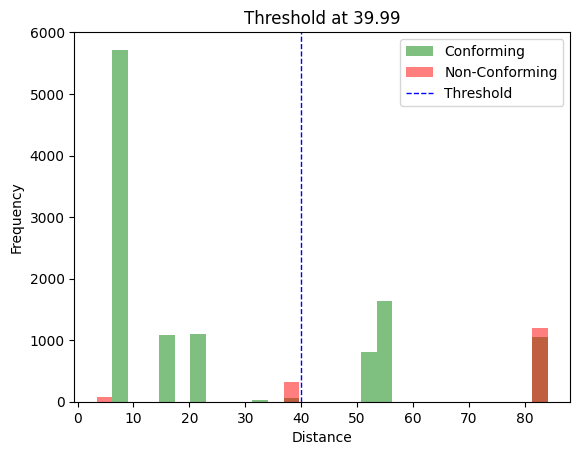

In [16]:
from sklearn.cluster import KMeans

# Filter the DataFrame into conforming and non-conforming subsets
conforming_distances = results[results['conform'] == 1]['distance']
non_conforming_distances = results[results['conform'] == 0]['distance']

# Determine common bin edges
min_distance = min(results['distance'])
max_distance = max(results['distance'])
bin_edges = np.linspace(min_distance, max_distance, num=30)

# Combine the data and reshape for k-means
all_distances = results['distance']
all_distances = np.array(all_distances)
all_distances_reshaped = all_distances.reshape(-1, 1)

# Apply k-means clustering
kmeans = KMeans(n_clusters=2, random_state=0).fit(all_distances_reshaped)
kmeans_labels = kmeans.labels_

# Find the threshold as the average of the two cluster centers
threshold_value = np.mean(kmeans.cluster_centers_)

# Plot histograms and the threshold
plt.hist(conforming_distances, bins=bin_edges, alpha=0.5, label='Conforming', color='green')
plt.hist(non_conforming_distances, bins=bin_edges, alpha=0.5, label='Non-Conforming', color='red')
plt.axvline(threshold_value, color='blue', linestyle='dashed', linewidth=1, label='Threshold')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title(f'Threshold at {threshold_value:.2f}')
plt.show()

In [17]:
true_positive = np.sum(results[results['conform'] == 1]['distance'] < threshold_value)
true_negative = np.sum(results[results['conform'] == 0]['distance'] > threshold_value)
false_positive = np.sum(results[results['conform'] == 0]['distance'] < threshold_value)
false_negative = np.sum(results[results['conform'] == 1]['distance'] > threshold_value)

In [18]:
# Calculate accuracy
accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.702


In [19]:
# Calculate precision
precision = true_positive / (true_positive + false_positive)
print(f"Precision: {precision:.3f}")

Precision: 0.952


In [20]:
# Calculate recall
recall = true_positive / (true_positive + false_negative)
print(f"Recall: {recall:.3f}")

Recall: 0.696


In [21]:
# Calculate f1
f1 = 2 * ((precision * recall) / (precision + recall))
print(f"F1: {f1:.3f}")

F1: 0.804


# Dev (Non Conform Traces)

In [22]:
# Calculate precision for Dev
precision = true_negative / (true_negative + false_negative)
print(f"Precision: {precision:.3f}")

Precision: 0.254


In [23]:
# Calculate recall for Dev
recall = true_negative / (true_negative + false_positive)
print(f"Recall: {recall:.3f}")

Recall: 0.749


# No Dev (Conform Traces)

In [24]:
# Calculate precision for No Dev
precision = true_positive / (true_positive + false_positive)
print(f"Precision: {precision:.3f}")

Precision: 0.952


In [25]:
# Calculate recall for No Dev
recall = true_positive / (true_positive + false_negative)
print(f"Recall: {recall:.3f}")

Recall: 0.696


# AUC_ROC

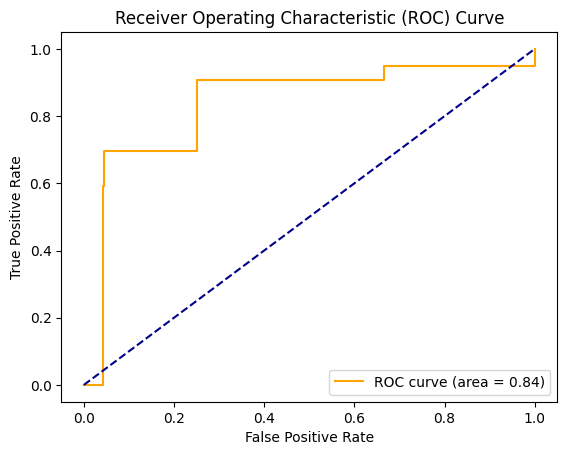

ROC AUC: 0.838


In [26]:
# UPDATED

import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming 'results' is your DataFrame and 'distance' is the score to predict conformity

# Inverting the 'distance' scores because higher scores indicate non-conformity
# We invert the scores for ROC AUC calculation because roc_auc_score expects higher values
# to indicate higher likelihood of the positive class
inverted_scores = 1 - results['distance']

# Calculate the ROC curve and AUC using inverted scores
fpr, tpr, thresholds = roc_curve(results['conform'], inverted_scores, pos_label=1)
roc_auc = roc_auc_score(results['conform'], inverted_scores)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='orange', label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print the AUC
print(f"ROC AUC: {roc_auc:.3f}")